In [18]:
import sys
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping
from PIL import Image
import scipy.ndimage as ndimage
from scipy.ndimage.filters import convolve

In [19]:
#a=[(1,2,3.0),(3,4,2.0),(9,8,1.0)]
#sort_ind = np.argsort(np.array(a)[:,2])
#print(sort_ind)
#rev_ind=np.flip(sort_ind)
#print(rev_ind)

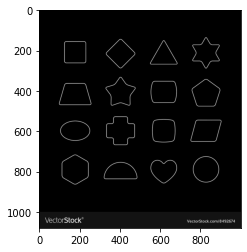

In [66]:
#loading the image
image=mping.imread('toy_image.jpg').astype('float64')
image=image/255.0
#plt.imshow(image)
#plt.show()
red_channel=image[:,:,0]
green_channel=image[:,:,1]
blue_channel=image[:,:,2]
lum_image=((0.2989*red_channel) + (0.5870*green_channel) + (0.1140*blue_channel))
#plt.imshow(image[:,:,2])
#lum_image=cv2.GaussianBlur(lum_image,(5,5), 1 )
plt.imshow(lum_image,cmap=plt.get_cmap('gray'))
plt.show()

In [59]:
def get_gradient(image):
  x_dir=np.asarray([[1,0,-1],[1,0,-1],[1,0,-1]],np.float64)
  y_dir=np.asarray([[1,1,1],[0,0,0],[-1,-1,-1]],np.float64)
  gradient_x=ndimage.convolve(image,x_dir)
  gradient_y=ndimage.convolve(image,y_dir)
  #magnitude_gradient=np.hypot(gradient_x,gradient_y)
  #direction_gradient=np.arctan2(gradient_y,gradient_x)
  #print(magnitude_gradient.shape)

  return (gradient_x,gradient_y)



In [22]:
def get_corner_response(image,gradient_x,gradient_y):
  h=gradient_x.shape[0]
  w=gradient_x.shape[1]

  gradient_x_2=np.zeros_like(gradient_x,np.float64)
  gradient_y_2=np.zeros_like(gradient_y,np.float64)

  gradient_xy=np.zeros_like(gradient_x,np.float64)
  cov_matrix=np.zeros_like(image,np.float64)

  for i in range(h):
    for j in range(w):
      gradient_x_2[i][j]=gradient_x[i][j]**2
      gradient_y_2[i][j]=gradient_y[i][j]**2
      gradient_xy[i][j]=gradient_x[i][j]*gradient_y[i][j]

  m=4
  k=0.04
  for i in range(m,(h-m)):
    for j in range(m,(w-m)):
      mat_x_2=gradient_x_2[i-m : i+m+1, j-m : j+m+1]
      mat_y_2=gradient_y_2[i-m : i+m+1, j-m : j+m+1]
      mat_xy=gradient_xy[i-m : i+m+1, j-m : j+m+1]

      sum_x_2=mat_x_2.sum()
      sum_y_2=mat_y_2.sum()
      sum_xy=mat_xy.sum()

      e_value=(((sum_x_2*sum_y_2)-(sum_xy**2))-(k*((sum_x_2+sum_y_2)**2)))
      cov_matrix[i][j]=e_value

  
  return cov_matrix

    



In [23]:
def get_corner_threshold(image,cov_matrix,t_ratio):
  max_response=cov_matrix.max()
  t_value=t_ratio*max_response

  h=image.shape[0]
  w=image.shape[1]

  list_corners=[]

  for i in range(h):
    for j in range(w):
      if (cov_matrix[i][j]>t_value):
        x=i
        y=j
        e_value=cov_matrix[i][j]
        list_corners.append([x,y,e_value])

  return list_corners

  


In [24]:
def check_neighbourhood(test_x,test_y,x,y):
  if ((test_x==x+1) and (test_y==y+1)):
    return True

  elif ((test_x==x+1) and (test_y==y)):
    return True

  elif ((test_x==x+1) and (test_y==y-1)):
    return True

  elif ((test_x==x) and (test_y==y+1)):
    return True

  elif ((test_x==x) and (test_y==y)):
    return True

  elif ((test_x==x) and (test_y==y-1)):
    return True

  elif ((test_x==x-1) and (test_y==y+1)):
    return True

  elif ((test_x==x-1) and (test_y==y)):
    return True

  elif ((test_x==x-1) and (test_y==y-1)):
    return True

  else:
    return False

In [25]:
def sup_corners(list_corners):
  indces_sorted=np.argsort(np.array(list_corners)[:,2])
  indces_sorted=np.flip(indces_sorted)
  list_final=[]
  length=len(indces_sorted)
  for i in range(length):
    if (list_corners[indces_sorted[i]][0]!= -1):
      x_cord=list_corners[indces_sorted[i]][0]
      y_cord=list_corners[indces_sorted[i]][1]
      e_value=list_corners[indces_sorted[i]][2]
      list_final.append([x_cord,y_cord,e_value])
      list_corners[indces_sorted[i]][0]=-1
      list_corners[indces_sorted[i]][1]=-1
      x=list_corners[indces_sorted[i]][0]
      y=list_corners[indces_sorted[i]][1]

      for j in range(len(list_corners)):
        test_x=list_corners[j][0]
        test_y=list_corners[j][1]

        if (list_corners[j][0]!=-1) and (check_neighbourhood(test_x,test_y,x,y)):
          list_corners[j][0]=-1
          list_corners[j][1]=-1

  

  return list_final


In [26]:
def mark_corners(image,list_final):
  length=len(list_final)

  output_image=image.copy()

  for i in range(length):
    x_cord=list_final[i][0]
    y_cord=list_final[i][1]
    x_cord=int(x_cord)
    y_cord=int(y_cord)
    output_image[x_cord][y_cord][0]=0.0
    output_image[x_cord][y_cord][1]=1.0
    output_image[x_cord][y_cord][2]=0.0

    for j in range(y_cord-3 , y_cord+4):
      output_image[x_cord][j][0]=0.0
      output_image[x_cord][j][1]=1.0
      output_image[x_cord][j][2]=0.0

    for j in range(x_cord-3,x_cord+4):
      output_image[j][y_cord][0]=0.0
      output_image[j][y_cord][1]=1.0
      output_image[j][y_cord][2]=0.0

    cv2.circle(output_image, (x_cord, y_cord), 4, (0, 1, 0))

  return output_image


In [73]:
gradient_x,gradient_y=get_gradient(lum_image)
cov_matrix= get_corner_response(lum_image,gradient_x,gradient_y)


In [74]:
list_corners=get_corner_threshold(lum_image,cov_matrix,0.40)

In [75]:
list_final=sup_corners(list_corners)
print(len(list_final))
# bird- 6354 final corners
# plane - 1126 final corners
# dog - 1343
# einstein - 2025
# plane- 209
# toy- 6933

1558


In [76]:
image=mping.imread('toy_image.jpg').astype('float64')
image=image/255.0

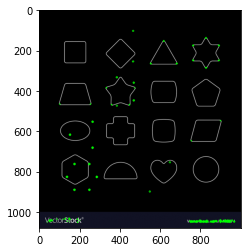

In [77]:
output_image=mark_corners(image,list_final)
plt.imshow(output_image,cmap=plt.get_cmap('gray'))
plt.show()

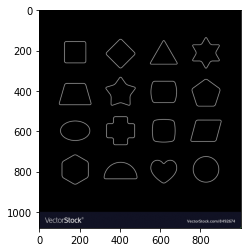

In [78]:

before_suppression=mark_corners(image,list_corners)
plt.imshow(before_suppression,cmap=plt.get_cmap('gray'))
plt.show()